In [37]:
# Download from https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

import pandas as pd
import requests
import io

url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'

r = requests.post(url)
if r.ok:
    data = r.content.decode('utf8')
    df = pd.read_csv(io.StringIO(data))
    
# Rename Province/State and Country/Region
df = df.rename(columns={'Province/State': 'provincestate', 'Country/Region': 'countryregion'})

# Remove unneeded columns
df = df.drop(['Lat', 'Long', 'provincestate'], axis=1)

# Reshape 
df_confirmed = df.melt(var_name='date', value_name='confirmed', id_vars='countryregion')

df_confirmed.head(10)


,countryregion,date,confirmed
0,Thailand,1/22/20,2
1,Japan,1/22/20,2
2,Singapore,1/22/20,0
3,Nepal,1/22/20,0
4,Malaysia,1/22/20,0
5,Canada,1/22/20,0
6,Australia,1/22/20,0
7,Australia,1/22/20,0
8,Australia,1/22/20,0
9,Cambodia,1/22/20,0


In [41]:
### Group values

df_confirmed['date'] = pd.to_datetime(df_confirmed['date']).dt.date
# print(df_confirmed)

df_confirmed_grouped = df_confirmed[['date','countryregion', 'confirmed']].groupby(['date', 'countryregion']).sum()

# df_confirmed_grouped.head(30)

print(df_confirmed_grouped)

                                           confirmed
date       countryregion                            
2020-01-22 Afghanistan                             0
           Albania                                 0
           Algeria                                 0
           Andorra                                 0
           Antigua and Barbuda                     0
...                                              ...
2020-03-16 Uruguay                                 8
           Uzbekistan                              6
           Venezuela                              17
           Vietnam                                61
           occupied Palestinian territory          0

[8580 rows x 1 columns]


In [56]:
# # Sort by day by country
# df_confirmed_grouped.sort_values('confirmed').head(50)

In [57]:
# Prepare China
df_china = df_confirmed_grouped.query('countryregion == "China"')
df_china_prepared = df_china.droplevel('countryregion').rename(columns=lambda x: x+' (china)').reset_index().melt(id_vars="date")

df_china_prepared.head(10)

,date,variable,value
0,2020-01-22,confirmed (china),548
1,2020-01-23,confirmed (china),643
2,2020-01-24,confirmed (china),920
3,2020-01-25,confirmed (china),1406
4,2020-01-26,confirmed (china),2075
5,2020-01-27,confirmed (china),2877
6,2020-01-28,confirmed (china),5509
7,2020-01-29,confirmed (china),6087
8,2020-01-30,confirmed (china),8141
9,2020-01-31,confirmed (china),9802


In [64]:
# Prepare non-China
df_not_china = df_confirmed_grouped.query('countryregion != "China"')
df_not_china_prepared = df_not_china.sum(level='date').fillna(0).rename(columns=lambda x: x+' (non-china)').reset_index().melt(id_vars="date")
df_not_china_prepared.head(10)

,date,variable,value
0,2020-01-22,confirmed (non-china),7
1,2020-01-23,confirmed (non-china),10
2,2020-01-24,confirmed (non-china),21
3,2020-01-25,confirmed (non-china),28
4,2020-01-26,confirmed (non-china),43
5,2020-01-27,confirmed (non-china),50
6,2020-01-28,confirmed (non-china),69
7,2020-01-29,confirmed (non-china),79
8,2020-01-30,confirmed (non-china),93
9,2020-01-31,confirmed (non-china),125


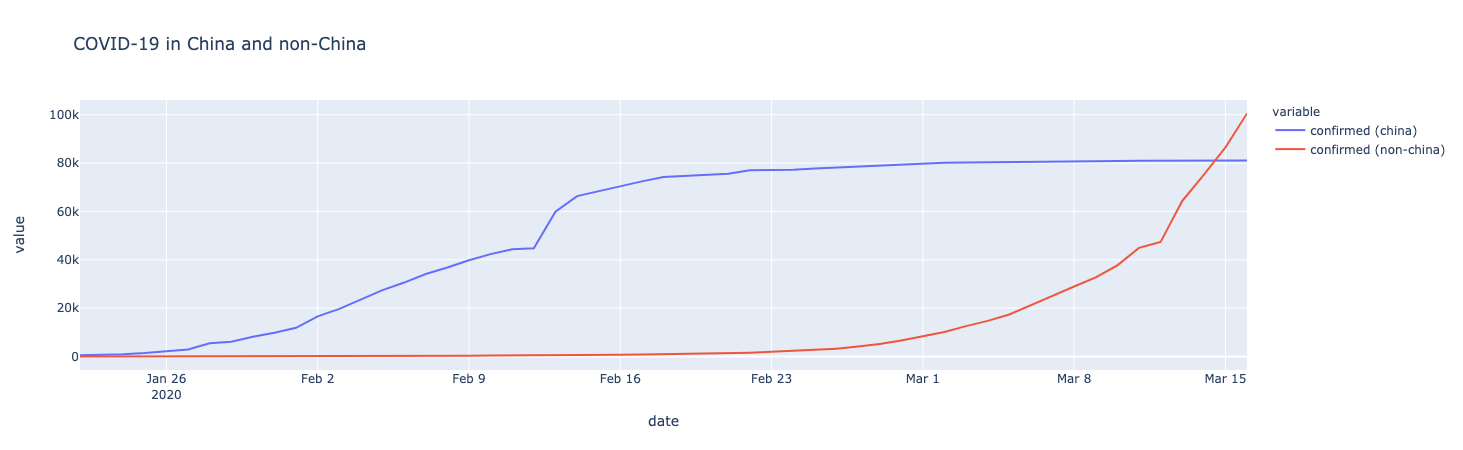

In [65]:
# Show fig
import plotly.express as px
fig = px.line(pd.concat([df_china_prepared, df_not_china_prepared]), x='date', y='value', color='variable', title='COVID-19 in China and non-China')
fig.show()